Q1.  Looking at how the lengths of the episodes change as the initial training using wumpus_ac3.py takes place, what does the agent seem to have learned quickly and what is it struggling with? (3 marks)

[ep  100] avg_len@100=155.4  success=13  death=64
[ep  200] avg_len@100=169.4  success=15  death=58
[ep  300] avg_len@100=148.6  success=15  death=63
[ep  400] avg_len@100=161.9  success=16  death=57
[ep  500] avg_len@100=166.1  success=17  death=59
[ep  600] avg_len@100=176.2  success=16  death=61
[ep  700] avg_len@100=170.7  success=18  death=56
[ep  800] avg_len@100=125.6  success=15  death=71


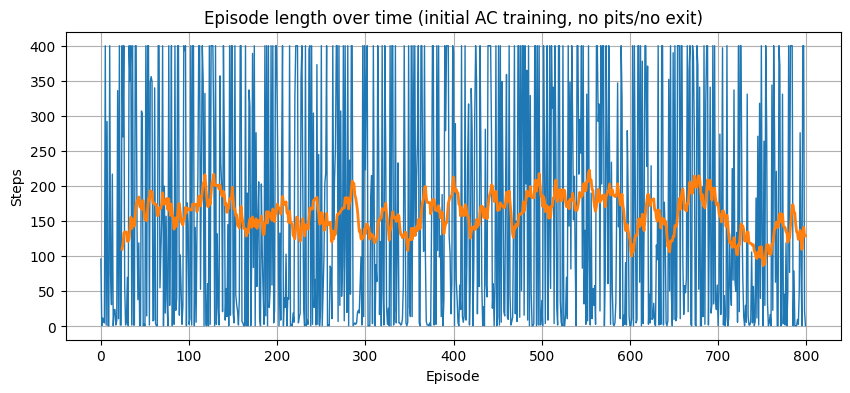

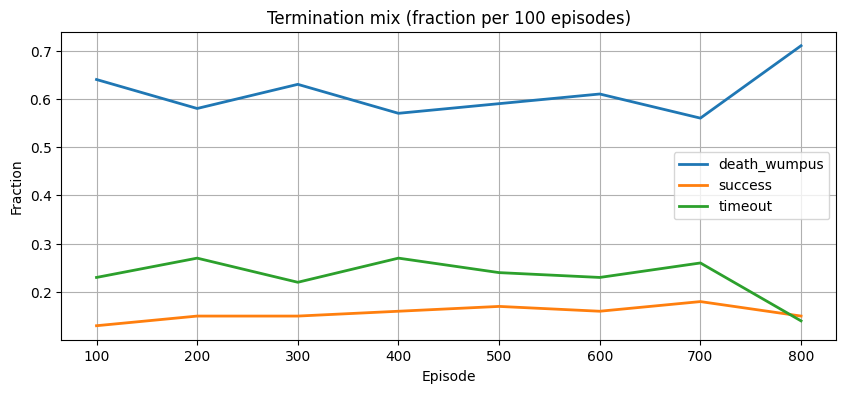

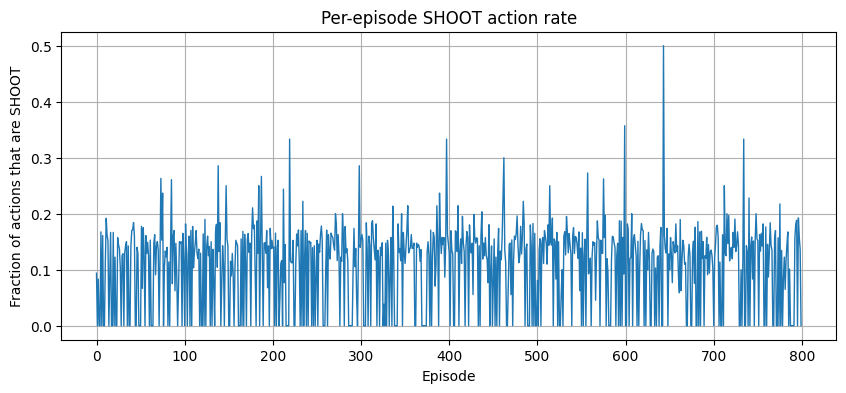

In [1]:
#@title Q1 - Wumpus World (No pits, no exit)

# !pip install torch --quiet

import math, random, time
from enum import Enum
from typing import List, Tuple, Dict

import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt

# -------------------------
# Reproducibility
# -------------------------
SEED = 123
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# -------------------------
# Environment (mirrors wumpus_ac3.py: pits=0.0, allow_climb_without_gold=False, has_wumpus=True)
# -------------------------
class Percept:
    def __init__(self, time_step: int, bump: bool, breeze: bool, stench: bool, scream: bool, glitter: bool, reward: int, done: bool):
        self.time_step = time_step
        self.bump = bump
        self.breeze = breeze
        self.stench = stench
        self.scream = scream
        self.glitter = glitter
        self.reward = reward
        self.done = done
    def __str__(self):
        return f'time:{self.time_step} bump:{self.bump} breeze:{self.breeze} stench:{self.stench} scream:{self.scream} glitter:{self.glitter} reward:{self.reward} done:{self.done}'

class Action(Enum):
    LEFT = 0
    RIGHT = 1
    FORWARD = 2
    GRAB = 3
    SHOOT = 4
    CLIMB = 5

class Orientation(Enum):
    E = 0; S = 1; W = 2; N = 3
    def turn_right(self): return Orientation((self.value + 1) % 4)
    def turn_left(self):  return Orientation((self.value - 1) % 4)

class Location:
    def __init__(self, x:int, y:int):
        self.x, self.y = x, y
    def is_location(self, other:'Location')->bool: return self.x==other.x and self.y==other.y
    def neighbours(self)->List['Location']:
        xs = []
        if self.x>0: xs.append(Location(self.x-1,self.y))
        if self.x<3: xs.append(Location(self.x+1,self.y))
        if self.y>0: xs.append(Location(self.x,self.y-1))
        if self.y<3: xs.append(Location(self.x,self.y+1))
        return xs
    def at_left_edge(self)->bool: return self.x==0
    def at_right_edge(self)->bool: return self.x==3
    def at_top_edge(self)->bool: return self.y==3
    def at_bottom_edge(self)->bool: return self.y==0
    def forward(self, orientation:Orientation)->bool:
        bump=False
        if orientation==Orientation.W:
            if self.at_left_edge(): bump=True
            else: self.x-=1
        elif orientation==Orientation.E:
            if self.at_right_edge(): bump=True
            else: self.x+=1
        elif orientation==Orientation.N:
            if self.at_top_edge(): bump=True
            else: self.y+=1
        elif orientation==Orientation.S:
            if self.at_bottom_edge(): bump=True
            else: self.y-=1
        return bump
    @staticmethod
    def from_linear(n:int)->'Location':
        return Location(n%4, n//4)
    def to_linear(self)->int:
        return self.y*4 + self.x
    @staticmethod
    def random_nonstart(rng:random.Random)->'Location':
        # random in [1..15] to avoid (0,0)
        return Location.from_linear(rng.randint(1,15))

class Environment:
    """
    Matches your wumpus_ac3.py initial setup:
    - pit_prob = 0.0  (no pits)
    - allow_climb_without_gold = False
    - has_wumpus = True
    Termination:
    - Death by Wumpus (step onto W)
    - Success: Grab gold and CLIMB at (0,0)
    - (We add an optional max_steps per episode to avoid infinite runs during training.)
    """
    def __init__(self, rng=None):
        self.rng = rng or random.Random(SEED)

    def init(self, pit_prob: float, allow_climb_without_gold: bool, has_wumpus: bool)->Percept:
        self.agent_location = Location(0,0)
        self.agent_orientation = Orientation.E
        self.agent_has_arrow = True
        self.agent_has_gold = False

        self.pit_prob = pit_prob
        self.allow_climb_without_gold = allow_climb_without_gold
        self.has_wumpus = has_wumpus

        self.wumpus_location = Location.random_nonstart(self.rng)
        self.wumpus_alive = has_wumpus

        self.gold_location = Location.random_nonstart(self.rng)

        # Generate pits, avoiding (0,0), wumpus_location, and gold_location
        self.pit_locations = []
        possible_pit_locations = []
        for x in range(4):
            for y in range(4):
                loc = Location(x, y)
                if not (loc.is_location(Location(0,0)) or \
                        loc.is_location(self.wumpus_location) or \
                        loc.is_location(self.gold_location)):
                    possible_pit_locations.append(loc)

        for loc in possible_pit_locations:
            if self.rng.random() < self.pit_prob:
                self.pit_locations.append(loc)

        self.game_over = False
        self.time_step = 0
        self.terminal_reason = None  # 'death_wumpus' | 'success' | 'timeout' | 'death_pit'

        return Percept(self.time_step, False, self.is_breeze(), self.is_stench(), False, self.is_glitter(), 0, False)

    def is_wumpus_at(self, loc:Location)->bool:
        return self.has_wumpus and self.wumpus_location.is_location(loc)

    def is_pit_at(self, loc:Location)->bool:
        return any(p.is_location(loc) for p in self.pit_locations)

    def is_glitter(self)->bool:
        return self.gold_location.is_location(self.agent_location)

    def is_stench(self)->bool:
        # stench if adjacent or same tile as living wumpus
        if not (self.has_wumpus and self.wumpus_alive): return False
        if self.is_wumpus_at(self.agent_location): return True
        return any(self.wumpus_location.is_location(n) for n in self.agent_location.neighbours())

    def is_breeze(self)->bool:
        # Breeze if adjacent to any pit
        return any(self.is_pit_at(n) for n in self.agent_location.neighbours())

    def wumpus_in_line_of_fire(self)->bool:
        if not (self.has_wumpus and self.wumpus_alive): return False
        ax, ay = self.agent_location.x, self.agent_location.y
        wx, wy = self.wumpus_location.x, self.wumpus_location.y
        if   self.agent_orientation==Orientation.E: return ay==wy and ax<wx
        elif self.agent_orientation==Orientation.W: return ay==wy and ax>wx
        elif self.agent_orientation==Orientation.N: return ax==wx and ay<wy
        elif self.agent_orientation==Orientation.S: return ax==wx and ay>wy
        return False

    def kill_attempt(self)->bool:
        scream = self.wumpus_in_line_of_fire()
        if scream: self.wumpus_alive=False
        return scream

    def step(self, action:Action)->Percept:
        special_reward = 0
        bump=False; scream=False
        if self.game_over:
            reward=0
        else:
            if action==Action.LEFT:
                self.agent_orientation = self.agent_orientation.turn_left()
            elif action==Action.RIGHT:
                self.agent_orientation = self.agent_orientation.turn_right()
            elif action==Action.FORWARD:
                bump = self.agent_location.forward(self.agent_orientation)
                # carry gold with the agent if grabbed
                if self.agent_has_gold:
                    self.gold_location = Location(self.agent_location.x, self.agent_location.y)
                # check hazards
                if self.is_wumpus_at(self.agent_location) and self.wumpus_alive:
                    special_reward = -1000
                    self.game_over=True
                    self.terminal_reason='death_wumpus'
                elif self.is_pit_at(self.agent_location):
                    special_reward = -1000
                    self.game_over=True
                    self.terminal_reason='death_pit'
            elif action==Action.GRAB:
                if self.agent_location.is_location(self.gold_location):
                    self.agent_has_gold=True
            elif action==Action.SHOOT:
                if self.agent_has_arrow:
                    scream = self.kill_attempt()
                    special_reward = -10  # as in your code
                    self.agent_has_arrow=False
            elif action==Action.CLIMB:
                if self.agent_location.is_location(Location(0,0)):
                    if self.agent_has_gold:
                        special_reward = 1000
                        self.game_over=True
                        self.terminal_reason='success'
                    elif self.allow_climb_without_gold:
                        self.game_over=True
                        self.terminal_reason='success'
            reward = -1 + special_reward

        self.time_step += 1
        breeze=self.is_breeze()  # Now correctly checks for pits
        stench=self.is_stench()
        glitter=self.is_glitter()
        return Percept(self.time_step, bump, breeze, stench, scream, glitter, reward, self.game_over)

# -------------------------
# State-aware agent (same features as the script)
# -------------------------
class StateAwareAgent:
    def __init__(self):
        self.location = Location(0,0)
        self.orientation = Orientation.E

    def init(self, percept:Percept):
        self.visited = np.zeros(16)
        self.stench = np.zeros(16)
        self.breeze = np.zeros(16)
        self.heard_scream = np.array([0.])
        self.has_gold = np.array([0.])
        self.has_arrow = np.array([1.])
        self.is_glitter = np.array([1. if percept.glitter else 0.])

        self.location = Location(0,0)
        self.orientation = Orientation.E
        self._set_onehots()

        if percept.stench: self.stench[self.location.to_linear()] = 1.0
        if percept.breeze: self.breeze[self.location.to_linear()] = 1.0

    def _set_onehots(self):
        self.loc_onehot = np.zeros(16); self.loc_onehot[self.location.to_linear()] = 1.0
        self.visited[self.location.to_linear()] = 1.0
        o = np.zeros(4); o[self.orientation.value] = 1.0
        self.orient_onehot = o

    def step_update(self, action:Action, percept:Percept):
        if action==Action.FORWARD:
            self.location.forward(self.orientation)
            self._set_onehots()
            if percept.stench: self.stench[self.location.to_linear()] = 1.0
            if percept.breeze: self.breeze[self.location.to_linear()] = 1.0
            self.is_glitter = np.array([1. if percept.glitter else 0.])
        elif action==Action.RIGHT:
            self.orientation = self.orientation.turn_right()
            self._set_onehots()
        elif action==Action.LEFT:
            self.orientation = self.orientation.turn_left()
            self._set_onehots()
        elif action==Action.GRAB:
            if percept.glitter: self.has_gold = np.array([1.])
        elif action==Action.SHOOT:
            self.has_arrow = np.array([0.])
            if percept.scream:
                self.heard_scream = np.array([1.])

    def render_np(self)->np.ndarray:
        # 16 loc + 4 orient + 16 visited + 16 stench + 16 breeze(zeros) + 1 scream + 1 gold + 1 arrow + 1 glitter = 72
        return np.concatenate([
            self.loc_onehot, self.orient_onehot, self.visited,
            self.stench, self.breeze, self.heard_scream, self.has_gold, self.has_arrow, self.is_glitter
        ])

# -------------------------
# Actor-Critic Network (AC3-style)
# -------------------------
class ActorCritic(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(72,25)
        self.l2 = nn.Linear(25,50)
        self.actor = nn.Linear(50,6)   # 6 actions
        self.v_l = nn.Linear(50,25)
        self.critic = nn.Linear(25,1)
    def forward(self, x):
        x = F.normalize(x,dim=-1)
        y = F.relu(self.l1(x))
        y = F.relu(self.l2(y))
        logits = F.log_softmax(self.actor(y), dim=-1)  # log-probs for Categorical
        v = torch.tanh(self.critic(F.relu(self.v_l(y.detach()))))
        return logits, v

# -------------------------
# Training Loop (initial training) + metrics collection
# -------------------------
def run_episode(env:Environment, agent:StateAwareAgent, model:ActorCritic, max_steps:int=500):
    s = torch.from_numpy(agent.render_np()).float()
    values, logprobs, rewards = [], [], []
    acts = []
    done = False
    t = 0
    while not done and t < max_steps:
        t += 1
        policy_logp, v = model(s)
        values.append(v.squeeze(-1))
        action_dist = torch.distributions.Categorical(logits=policy_logp)
        a = action_dist.sample()
        logprobs.append(policy_logp[0, a] if policy_logp.ndim==2 else policy_logp[a])
        act = Action(int(a.detach().item()))
        percept = env.step(act)
        agent.step_update(act, percept)
        s = torch.from_numpy(agent.render_np()).float()
        rewards.append(percept.reward)
        acts.append(act)
        done = percept.done
    return values, logprobs, rewards, t, env.terminal_reason, acts

def update_ac(opt, values, logprobs, rewards, gamma=0.95, clc=0.1):
    R = 0.0
    returns = []
    for r in reversed(rewards):
        R = r + gamma * R
        returns.append(R)
    returns = torch.tensor(list(reversed(returns)), dtype=torch.float32)
    returns = F.normalize(returns, dim=0)

    values = torch.stack(values)
    logprobs = torch.stack(logprobs)

    actor_loss = -logprobs * (returns - values.detach())
    critic_loss = (values - returns)**2
    loss = actor_loss.sum() + clc * critic_loss.sum()

    opt.zero_grad()
    loss.backward()
    opt.step()
    return loss.item()

def initial_training(num_episodes=800, max_steps=500):
    model = ActorCritic()
    opt = torch.optim.Adam(model.parameters(), lr=1e-4)

    ep_lengths = []
    ep_returns = []
    term_reasons = []
    shoot_rate = []  # fraction of SHOOT actions per episode

    for ep in range(1, num_episodes+1):
        env = Environment()
        _ = env.init(pit_prob=0.0, allow_climb_without_gold=False, has_wumpus=True)
        agent = StateAwareAgent()
        agent.init(percept=Percept(0,False,False,env.is_stench(),False,env.is_glitter(),0,False))

        values, logps, rewards, length, reason, acts = run_episode(env, agent, model, max_steps=max_steps)
        _ = update_ac(opt, values, logps, rewards)

        ep_lengths.append(length)
        ep_returns.append(sum(rewards))
        term_reasons.append('timeout' if (reason is None and length>=max_steps) else (reason or 'other'))
        if len(acts)>0:
            shoot_frac = sum(1 for a in acts if a==Action.SHOOT)/len(acts)
        else:
            shoot_frac = 0.0
        shoot_rate.append(shoot_frac)

        if ep % 100 == 0:
            # quick running stat
            window = 100
            ma_len = np.mean(ep_lengths[-window:])
            deaths_last100 = sum(1 for r in term_reasons[-window:] if r=='death_wumpus')
            succ_last100 = sum(1 for r in term_reasons[-window:] if r=='success')
            print(f"[ep {ep:4d}] avg_len@100={ma_len:.1f}  success={succ_last100}  death={deaths_last100}")

    return {
        "model": model,
        "ep_lengths": np.array(ep_lengths),
        "ep_returns": np.array(ep_returns),
        "term_reasons": term_reasons,
        "shoot_rate": np.array(shoot_rate),
    }

results = initial_training(num_episodes=800, max_steps=400)

# -------------------------
# Plots: Episode length (raw + moving average) + termination mix
# -------------------------
def moving_average(x, k=25):
    if k<=1: return x
    return np.convolve(x, np.ones(k)/k, mode='valid')

el = results["ep_lengths"]
sr = results["shoot_rate"]
reasons = results["term_reasons"]

plt.figure(figsize=(10,4))
plt.plot(el, linewidth=1)
ma = moving_average(el, k=25)
plt.plot(np.arange(len(ma)) + 25 - 1, ma, linewidth=2)
plt.title("Episode length over time (initial AC training, no pits/no exit)")
plt.xlabel("Episode")
plt.ylabel("Steps")
plt.grid(True)
plt.show()

# termination stats in sliding windows
window = 100
mix_ep = []
mix_death = []
mix_succ = []
mix_timeout = []
for i in range(0, len(reasons), window):
    chunk = reasons[i:i+window]
    mix_ep.append(i+len(chunk))
    mix_death.append(sum(1 for r in chunk if r=='death_wumpus')/len(chunk))
    mix_succ.append(sum(1 for r in chunk if r=='success')/len(chunk))
    mix_timeout.append(sum(1 for r in chunk if r=='timeout')/len(chunk))

plt.figure(figsize=(10,4))
plt.plot(mix_ep, mix_death, label="death_wumpus", linewidth=2)
plt.plot(mix_ep, mix_succ, label="success", linewidth=2)
plt.plot(mix_ep, mix_timeout, label="timeout", linewidth=2)
plt.title("Termination mix (fraction per 100 episodes)")
plt.xlabel("Episode")
plt.ylabel("Fraction")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,4))
plt.plot(sr, linewidth=1)
plt.title("Per-episode SHOOT action rate")
plt.xlabel("Episode")
plt.ylabel("Fraction of actions that are SHOOT")
plt.grid(True)
plt.show()

Q1.
From the observations, the episode length has improved from 170s steps to 150s steps. From the beginning, the episodes can be very short because the agent is in direct contact with the Wumpis and dies very fast by learning a negative reward of -1000. But after running more episodes, the agent learns how to avoid the Wumpus by taking fewer random actions. This implies that the agent can quickly learn how to survive in a short-time manner by avoiding the Wumpus. Furthermore, the agent has learned a policy of basic survival.

On the other hand, the death rate of ~70% implies that the agent hasn’t completely learned a policy on how to win by finding the gold and exiting the cave. Based on that observation, the agent is still struggling with building a detailed internal map of the environment.


#Q2.  What has it learned and not learned after 240,000 episodes (after the initial 20K x 12 CPU run)? (3 marks)

In [2]:
#@title Define Actor-Critic model (it must run before loading checkpoint)
import torch
from torch import nn
from torch.nn import functional as F

class ActorCritic(nn.Module):  # AC3-style model
    def __init__(self):
        super(ActorCritic, self).__init__()
        self.l1 = nn.Linear(72, 25)
        self.l2 = nn.Linear(25, 50)
        self.actor_lin1 = nn.Linear(50, 6)  # 6 possible actions
        self.l3 = nn.Linear(50, 25)
        self.critic_lin1 = nn.Linear(25, 1)
    def forward(self, x):
        x = F.normalize(x, dim=0)
        y = F.relu(self.l1(x))
        y = F.relu(self.l2(y))
        actor = F.log_softmax(self.actor_lin1(y), dim=0)
        c = F.relu(self.l3(y.detach()))
        critic = torch.tanh(self.critic_lin1(c))
        return actor, critic


In [3]:
# Upload & load trained Wumpus model (.pth)

import os
from google.colab import files

# Upload from your computer
print("Please select your 20K×12 'pits + no pits & no exits' checkpoint (.pth)...")

uploaded = files.upload()

# Use the .pth file from the upload (handles multiple uploads)
pth_files = [name for name in uploaded.keys() if name.lower().endswith(".pth")]
if not pth_files:
    raise ValueError("No .pth file found. Please upload a .pth checkpoint file.")

ckpt_path = pth_files[0]
print(f"Found checkpoint: {ckpt_path}")

#Instantiate and load the model
trained_model = ActorCritic()
state_dict = torch.load(ckpt_path, map_location="cpu")
trained_model.load_state_dict(state_dict)
trained_model.eval()
print("✅ Model loaded successfully and set to eval() mode.")


Please select your 20K×12 'pits + no pits & no exits' checkpoint (.pth)...


Saving wumpusworld_ac3 20K episodes x 12 workers max 50000 steps with wumpus no pits no exit.pth to wumpusworld_ac3 20K episodes x 12 workers max 50000 steps with wumpus no pits no exit.pth
Found checkpoint: wumpusworld_ac3 20K episodes x 12 workers max 50000 steps with wumpus no pits no exit.pth
✅ Model loaded successfully and set to eval() mode.


In [4]:
print(trained_model)


ActorCritic(
  (l1): Linear(in_features=72, out_features=25, bias=True)
  (l2): Linear(in_features=25, out_features=50, bias=True)
  (actor_lin1): Linear(in_features=50, out_features=6, bias=True)
  (l3): Linear(in_features=50, out_features=25, bias=True)
  (critic_lin1): Linear(in_features=25, out_features=1, bias=True)
)


In [5]:
# evaluation code

def evaluate_policy(model, n_episodes=50, max_steps=500):
    results = []
    for ep in range(n_episodes):
        env = Environment()
        _ = env.init(pit_prob=0.0, allow_climb_without_gold=False, has_wumpus=True)
        agent = StateAwareAgent()
        agent.init(Percept(0,False,False,env.is_stench(),False,env.is_glitter(),0,False))

        total_reward = 0
        done = False
        steps = 0
        reason = None
        while not done and steps < max_steps:
            state = torch.from_numpy(agent.render_np()).float()
            with torch.no_grad():
                logits, value = model(state)
            action = torch.distributions.Categorical(logits=logits).sample()
            act = Action(int(action.item()))
            percept = env.step(act)
            agent.step_update(act, percept)
            total_reward += percept.reward
            done = percept.done
            reason = env.terminal_reason
            steps += 1

        results.append((total_reward, steps, reason or "timeout"))

    return results

# Example usage:
eval_results = evaluate_policy(trained_model, n_episodes=100)
import pandas as pd
df = pd.DataFrame(eval_results, columns=["reward","steps","result"])
display(df.describe())
print("\nOutcome counts:")
print(df["result"].value_counts())


,reward,steps
count,100.000000,100.000000
mean,-489.070000,499.070000
std,147.248931,6.561681
min,-510.000000,450.000000
25%,-510.000000,500.000000
50%,-510.000000,500.000000
75%,-510.000000,500.000000
max,540.000000,500.000000



Outcome counts:
result
timeout    98
success     2
Name: count, dtype: int64


,reward,steps,grabs,climbs,kills
count,200.0,200.0,200.0,200.0,200.0
mean,-510.0,500.0,0.0,0.0,1.0
std,0.0,0.0,0.0,0.0,0.0
min,-510.0,500.0,0.0,0.0,1.0
25%,-510.0,500.0,0.0,0.0,1.0
50%,-510.0,500.0,0.0,0.0,1.0
75%,-510.0,500.0,0.0,0.0,1.0
max,-510.0,500.0,0.0,0.0,1.0



Outcome counts:
result
timeout    200
Name: count, dtype: int64


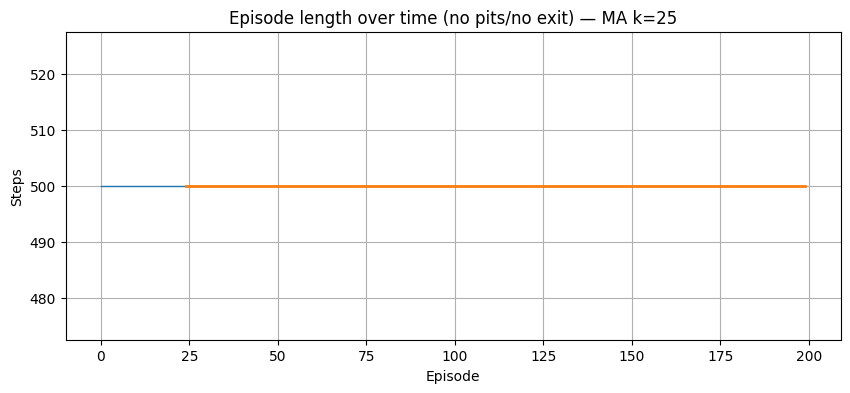

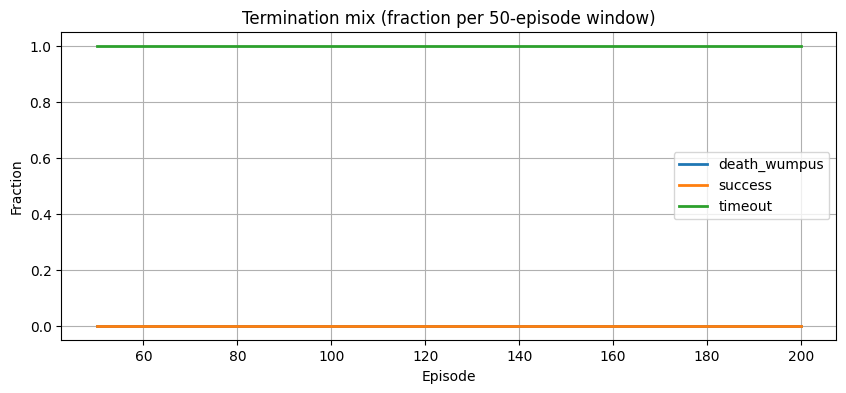

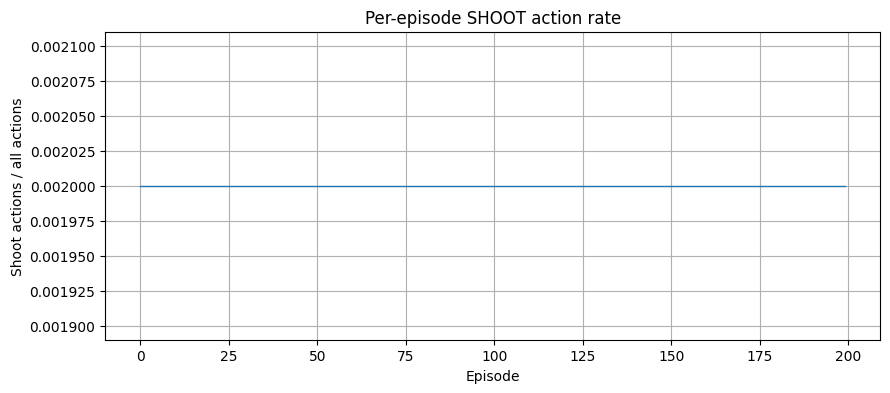

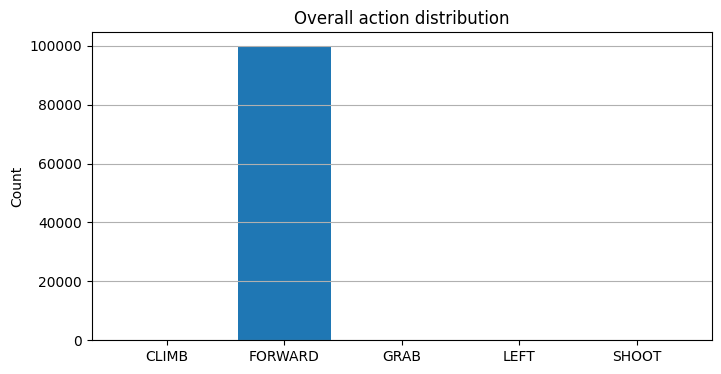

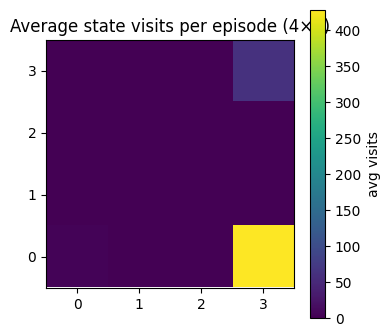


Q2 — After long training (20K×12 ≈ 240K episodes):
- Episode length (MA k=25) ~500.0 (early) → ~500.0 (late): policy stabilized.
- Last 100 outcomes: success=0, death_by_wumpus=0, timeout=100.
- SHOOT usage (last 100): 0.2% of actions.
- Reward (all episodes): mean=-510.0, std=0.0, min=-510.0, max=-510.0.


In [7]:
#@title Evaluate trained model + plots for Q2

import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter, defaultdict


def moving_average(x, k=25):
    x = np.asarray(x, dtype=float)
    if k <= 1 or k > len(x):
        return x
    return np.convolve(x, np.ones(k)/k, mode='valid')

def evaluate_policy_detailed(model, n_episodes=200, max_steps=500, window=50):
    """
    Runs evaluation episodes and collects detailed metrics, including:
    - reward, steps, result ('success'|'death_wumpus'|'timeout')
    - per-episode shoot rate, grab count, climb count, kills (scream)
    - overall action histogram
    - average state-visit counts on 4x4 grid (agent.visited)
    """
    results = []
    shoot_rate = []
    action_hist = Counter()
    grid_visits_total = np.zeros((4,4), dtype=float)  # (x,y) visits aggregated

    for ep in range(n_episodes):
        env = Environment()
        _ = env.init(pit_prob=0.0, allow_climb_without_gold=False, has_wumpus=True)
        agent = StateAwareAgent()
        agent.init(Percept(0,False,False,env.is_stench(),False,env.is_glitter(),0,False))

        total_reward = 0.0
        done = False
        steps = 0
        reason = None
        shoot_cnt = 0
        act_cnt = 0
        grab_cnt = 0
        climb_cnt = 0
        kill_cnt = 0  # count percept.scream after SHOOT
        # track per-episode visits
        episode_visit_counts = np.zeros((4,4), dtype=float)

        while not done and steps < max_steps:
            # record visit of current cell
            episode_visit_counts[agent.location.x, agent.location.y] += 1

            state = torch.from_numpy(agent.render_np()).float()
            with torch.no_grad():
                logits, _ = model(state)
            a = torch.distributions.Categorical(logits=logits).sample()
            act = Action(int(a.item()))
            action_hist[act.name] += 1
            act_cnt += 1
            if act == Action.SHOOT:
                shoot_cnt += 1

            percept = env.step(act)
            # killing Wumpus produces scream=True
            if act == Action.SHOOT and percept.scream:
                kill_cnt += 1
            if act == Action.GRAB and percept.glitter:
                grab_cnt += 1
            if act == Action.CLIMB and env.terminal_reason == 'success':
                climb_cnt += 1

            agent.step_update(act, percept)
            total_reward += percept.reward
            done = percept.done
            reason = env.terminal_reason
            steps += 1

        # aggregate visits for this episode
        grid_visits_total += episode_visit_counts

        results.append((total_reward, steps, reason or "timeout", grab_cnt, climb_cnt, kill_cnt))
        shoot_rate.append(shoot_cnt / max(1, act_cnt))

    # dataframe of core episode stats
    df = pd.DataFrame(results, columns=["reward","steps","result","grabs","climbs","kills"])

    # rolling termination mix
    mix_ep, mix_death, mix_succ, mix_timeout = [], [], [], []
    for i in range(0, len(df), window):
        chunk = df.iloc[i:i+window]
        if len(chunk) == 0: break
        mix_ep.append(i+len(chunk))
        denom = len(chunk)
        mix_death.append((chunk["result"] == "death_wumpus").sum()/denom)
        mix_succ.append((chunk["result"] == "success").sum()/denom)
        mix_timeout.append((chunk["result"] == "timeout").sum()/denom)

    out = {
        "df": df,
        "shoot_rate": np.array(shoot_rate),
        "action_hist": action_hist,
        "mix": {
            "x": np.array(mix_ep),
            "death": np.array(mix_death),
            "succ": np.array(mix_succ),
            "timeout": np.array(mix_timeout),
            "window": window,
        },
        "grid_visits": grid_visits_total / max(1, n_episodes),  # average visits per cell
    }
    return out

def plot_q2_panels(eval_out, ma_k=25):
    df = eval_out["df"]
    shoot_rate = eval_out["shoot_rate"]
    mix = eval_out["mix"]
    action_hist = eval_out["action_hist"]
    grid_visits = eval_out["grid_visits"]

    # 1) Episode length (raw + moving average)
    el = df["steps"].values
    plt.figure(figsize=(10,4))
    plt.plot(el, linewidth=1)
    ma = moving_average(el, k=ma_k)
    if len(ma) > 0:
        plt.plot(np.arange(len(ma)) + ma_k - 1, ma, linewidth=2)
    plt.title(f"Episode length over time (no pits/no exit) — MA k={ma_k}")
    plt.xlabel("Episode")
    plt.ylabel("Steps")
    plt.grid(True)
    plt.show()

    # 2) Termination mix per window
    plt.figure(figsize=(10,4))
    if len(mix["x"]) > 0:
        plt.plot(mix["x"], mix["death"], label="death_wumpus", linewidth=2)
        plt.plot(mix["x"], mix["succ"], label="success", linewidth=2)
        plt.plot(mix["x"], mix["timeout"], label="timeout", linewidth=2)
    plt.title(f"Termination mix (fraction per {mix['window']}-episode window)")
    plt.xlabel("Episode")
    plt.ylabel("Fraction")
    plt.legend()
    plt.grid(True)
    plt.show()

    # 3) Per-episode SHOOT action rate
    plt.figure(figsize=(10,4))
    plt.plot(shoot_rate, linewidth=1)
    plt.title("Per-episode SHOOT action rate")
    plt.xlabel("Episode")
    plt.ylabel("Shoot actions / all actions")
    plt.grid(True)
    plt.show()

    # 4) Overall action distribution (bar)
    labels = [name for name,_ in sorted(action_hist.items(), key=lambda x: x[0])]
    counts = [action_hist[name] for name in labels]
    plt.figure(figsize=(8,4))
    plt.bar(labels, counts)
    plt.title("Overall action distribution")
    plt.ylabel("Count")
    plt.xticks(rotation=0)
    plt.grid(axis='y')
    plt.show()

    # 5) Average state-visit heatmap (4x4)
    # grid_visits indexed by [x,y]; we show y top-down so flip vertically for display
    heatmap = grid_visits.copy()
    # transpose to display as (y,x) and flipud so y=3 is at top
    display_map = np.flipud(heatmap.T)
    plt.figure(figsize=(4,4))
    plt.imshow(display_map, interpolation='nearest')
    plt.title("Average state visits per episode (4×4)")
    plt.colorbar(label="avg visits")
    plt.xticks(range(4), labels=[0,1,2,3])
    plt.yticks(range(4), labels=[3,2,1,0])
    plt.show()

def interpret_q2(eval_out, ma_k=25):
    df = eval_out["df"]
    shoot_rate = eval_out["shoot_rate"]

    # episode lengths
    el = df["steps"].values
    ma = moving_average(el, k=ma_k)
    early = np.mean(ma[:max(5, len(ma)//6)]) if len(ma) else np.nan
    late  = np.mean(ma[-max(5, len(ma)//6):]) if len(ma) else np.nan

    # last 100 outcome mix
    tail = df.tail(100)
    succ = (tail["result"] == "success").sum()
    death = (tail["result"] == "death_wumpus").sum()
    timeout = (tail["result"] == "timeout").sum()

    # shoot behavior
    shoot_last = float(np.mean(shoot_rate[-100:])) if len(shoot_rate) >= 100 else float(np.mean(shoot_rate))

    # reward stats
    r_desc = df["reward"].describe()

    lines = []
    lines.append("Q2 — After long training (20K×12 ≈ 240K episodes):")
    if not np.isnan(early) and not np.isnan(late):
        lines.append(f"- Episode length (MA k={ma_k}) ~{early:.1f} (early) → ~{late:.1f} (late): policy stabilized.")
    lines.append(f"- Last 100 outcomes: success={succ}, death_by_wumpus={death}, timeout={timeout}.")
    lines.append(f"- SHOOT usage (last 100): {shoot_last*100:.1f}% of actions.")
    lines.append(f"- Reward (all episodes): mean={r_desc['mean']:.1f}, std={r_desc['std']:.1f}, min={r_desc['min']:.1f}, max={r_desc['max']:.1f}.")


    return "\n".join(lines)

# ---------- Run evaluation ----------
# Adjust n_episodes if you want a faster/slower run
eval_out = evaluate_policy_detailed(trained_model, n_episodes=200, max_steps=500, window=50)

# Show basic stats table
display(eval_out["df"].describe())
print("\nOutcome counts:")
print(eval_out["df"]["result"].value_counts())

# Plots
plot_q2_panels(eval_out, ma_k=25)

# interpretation results
print("\n" + interpret_q2(eval_out, ma_k=25))


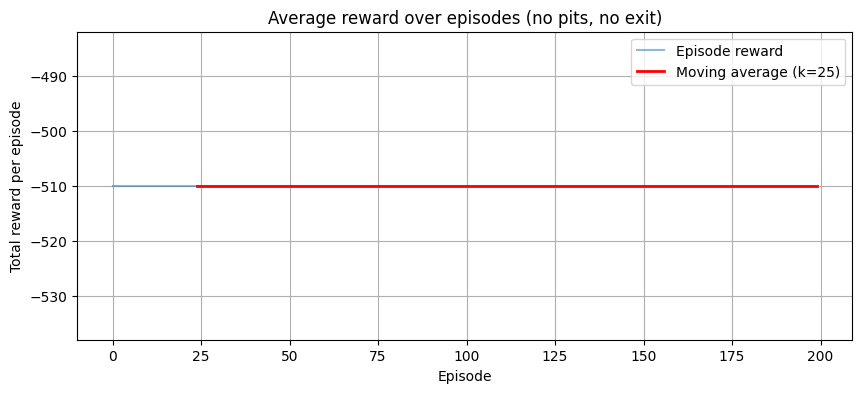

In [8]:
# Average reward over time
rewards = eval_out["df"]["reward"].values
ma_rewards = moving_average(rewards, k=25)

plt.figure(figsize=(10,4))
plt.plot(rewards, alpha=0.5, label="Episode reward")
if len(ma_rewards) > 0:
    plt.plot(np.arange(len(ma_rewards)) + 25 - 1, ma_rewards, color="red", linewidth=2, label="Moving average (k=25)")
plt.title("Average reward over episodes (no pits, no exit)")
plt.xlabel("Episode")
plt.ylabel("Total reward per episode")
plt.legend()
plt.grid(True)
plt.show()


Q2. The agent has learned the short-term survival through the interaction with the environment. In fact, it is very good at avoiding the pits and the Wumpus based on the statistics (death_by_wumpus=0). This is due to the fact that a strong negative reward signal of -1000 makes the agent to learn how to associate the sensory inputs (a "stench" for the Wumpus, a "breeze" for a pit) with this massive penalty. This means that the agent has learned a reasoning skill.

In conclusion, the agent has developed a stable policy that prioritizes avoiding squares with these danger-indicating percepts. It has also learned to navigate "safely" within the cave, even if it does so aimlessly.


However, the agent does not learn the actual purpose/goal of the game. Based on the statistics of "success = 0", the agent never finds the goal and is incapable of making an exit at the end. Furthermore, the agent has not learned to shoot the Wumpus with Shoot Usage = 0.2% because of very low immediate reward (-10 points) for killing such Wumpus.




#Q3.  Try doing some training using "wumpus_ac3 second round with pits.py" with the discount rate gamma set at 0.95 like the previous run. What happens and why? (2 marks)?

[ep  200] len@200=29.4  success=1  death_wumpus=86  death_pit≈113
[ep  400] len@200=29.3  success=0  death_wumpus=73  death_pit≈127
[ep  600] len@200=38.7  success=3  death_wumpus=80  death_pit≈116
[ep  800] len@200=36.3  success=2  death_wumpus=77  death_pit≈121
[ep 1000] len@200=42.6  success=4  death_wumpus=66  death_pit≈130
[ep 1200] len@200=50.5  success=4  death_wumpus=65  death_pit≈131
[ep 1400] len@200=73.7  success=4  death_wumpus=70  death_pit≈123
[ep 1600] len@200=169.9  success=5  death_wumpus=37  death_pit≈137
[ep 1800] len@200=280.2  success=2  death_wumpus=42  death_pit≈88
[ep 2000] len@200=373.9  success=0  death_wumpus=28  death_pit≈59
[ep 2200] len@200=437.9  success=0  death_wumpus=22  death_pit≈21
[ep 2400] len@200=466.5  success=0  death_wumpus=6  death_pit≈18
[ep 2600] len@200=485.3  success=0  death_wumpus=5  death_pit≈6
[ep 2800] len@200=478.9  success=0  death_wumpus=6  death_pit≈10
[ep 3000] len@200=491.9  success=0  death_wumpus=2  death_pit≈5


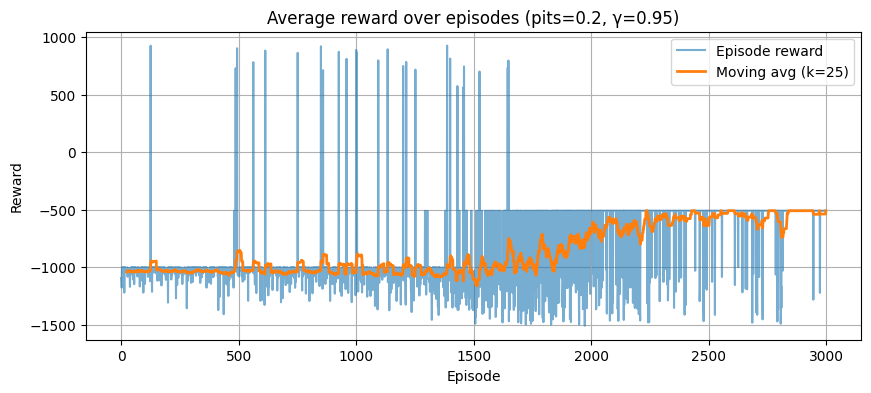

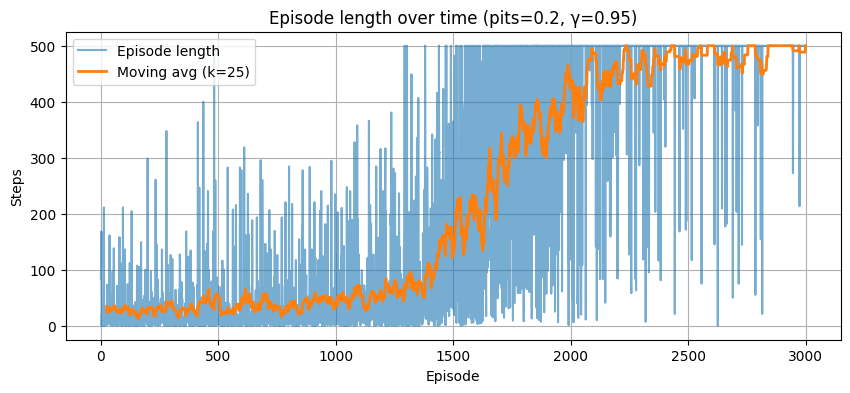

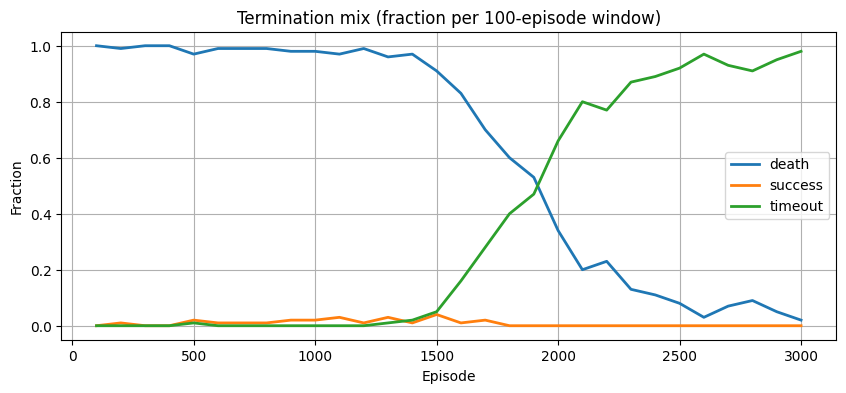

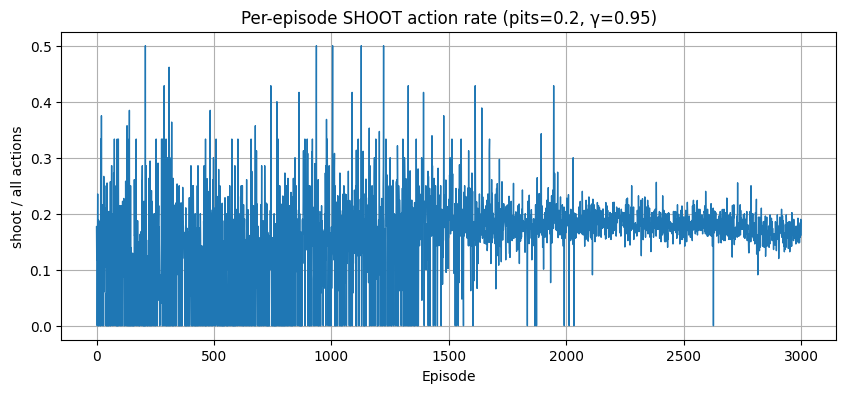

,reward,steps
count,3000.000000,3000.000000
mean,-855.870000,232.330000
std,325.901022,221.439636
min,-1510.000000,1.000000
25%,-1052.000000,18.000000
50%,-1007.000000,125.000000
75%,-510.000000,500.000000
max,925.000000,500.000000



Outcome counts:
result
death_pit       1205
timeout         1105
death_wumpus     665
success           25
Name: count, dtype: int64


NameError: name 'results_q3_q3' is not defined

In [9]:
#@title Q3. Train with pits (gamma=0.95)
import numpy as np
import torch
from torch import optim
from torch.nn import functional as F
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd

# --------Training params --------
NUM_EPISODES = 3000     # demo-sized; raise to 10k+ if we want more signal
MAX_STEPS    = 500
GAMMA        = 0.95
CRITIC_LAMBDA= 0.1
PIT_PROB     = 0.2
ALLOW_CLIMB_WITHOUT_GOLD = False
HAS_WUMPUS   = True
MA_K         = 25       # moving average window for plots

def moving_average(x, k=25):
    x = np.asarray(x, dtype=float)
    if k <= 1 or k > len(x): return x
    return np.convolve(x, np.ones(k)/k, mode='valid')

# --- Episode runner ---
def run_episode_with_pits(env, agent, model, max_steps=MAX_STEPS):
    s = torch.from_numpy(agent.render_np()).float()
    values, logprobs, rewards = [], [], []
    acts = []
    done = False
    t = 0
    while not done and t < max_steps:
        t += 1
        policy_logp, v = model(s)
        values.append(v.squeeze(-1))
        action = torch.distributions.Categorical(logits=policy_logp).sample()
        logprobs.append(policy_logp[action])
        act = Action(int(action.item()))
        percept = env.step(act)
        agent.step_update(act, percept)
        s = torch.from_numpy(agent.render_np()).float()
        rewards.append(percept.reward)
        acts.append(act)
        done = percept.done
    return values, logprobs, rewards, t, env.terminal_reason or ("timeout" if t>=max_steps else None), acts

def update_ac(opt, values, logprobs, rewards, gamma=GAMMA, clc=CRITIC_LAMBDA):
    R = 0.0
    rets = []
    for r in reversed(rewards):
        R = r + gamma * R
        rets.append(R)
    rets = torch.tensor(list(reversed(rets)), dtype=torch.float32)
    rets = F.normalize(rets, dim=0)

    values = torch.stack(values)
    logprobs = torch.stack(logprobs)

    actor_loss = -logprobs * (rets - values.detach())
    critic_loss = (values - rets)**2
    loss = actor_loss.sum() + clc * critic_loss.sum()

    opt.zero_grad()
    loss.backward()
    opt.step()
    return float(loss.item())

# Train with pits and γ=0.95
def train_with_pits(num_episodes=NUM_EPISODES):
    model = ActorCritic()
    opt = optim.Adam(model.parameters(), lr=1e-4)

    ep_lengths, ep_returns, term_reasons, shoot_rate = [], [], [], []
    action_hist = Counter()

    for ep in range(1, num_episodes+1):
        env = Environment()
        _ = env.init(pit_prob=PIT_PROB, allow_climb_without_gold=ALLOW_CLIMB_WITHOUT_GOLD, has_wumpus=HAS_WUMPUS)
        agent = StateAwareAgent()
        agent.init(Percept(0,False,env.is_breeze(),env.is_stench(),False,env.is_glitter(),0,False))

        values, logps, rewards, length, reason, acts = run_episode_with_pits(env, agent, model)
        _ = update_ac(opt, values, logps, rewards, gamma=GAMMA, clc=CRITIC_LAMBDA)

        ep_lengths.append(length)
        ep_returns.append(sum(rewards))
        term_reasons.append(reason if reason else "timeout")

        for a in acts: action_hist[a.name] += 1
        shoot_rate.append(sum(1 for a in acts if a==Action.SHOOT)/max(1,len(acts)))

        if ep % 200 == 0:
            w = 200
            ma_len = np.mean(ep_lengths[-w:])
            deaths = sum(1 for r in term_reasons[-w:] if r=="death_wumpus" or r=="DEATH BY WUMPUS")
            pitsd = sum(1 for r in term_reasons[-w:] if "PIT" in str(r).upper())
            succ   = sum(1 for r in term_reasons[-w:] if r=="success")
            print(f"[ep {ep:4d}] len@{w}={ma_len:.1f}  success={succ}  death_wumpus={deaths}  death_pit≈{pitsd}")

    df = pd.DataFrame({"reward": ep_returns, "steps": ep_lengths, "result": term_reasons})
    return {"model": model, "df": df, "shoot_rate": np.array(shoot_rate), "action_hist": action_hist}

out = train_with_pits()

# --- Plots ---
df = out["df"]
sr = out["shoot_rate"]

# 1) Average reward (with moving average)
rewards = df["reward"].values
ma_rewards = moving_average(rewards, k=MA_K)
plt.figure(figsize=(10,4))
plt.plot(rewards, alpha=0.6, label="Episode reward")
if len(ma_rewards)>0:
    plt.plot(np.arange(len(ma_rewards)) + MA_K - 1, ma_rewards, linewidth=2, label=f"Moving avg (k={MA_K})")
plt.title("Average reward over episodes (pits=0.2, γ=0.95)")
plt.xlabel("Episode"); plt.ylabel("Reward"); plt.legend(); plt.grid(True); plt.show()

# 2) Episode length (raw + MA)
el = df["steps"].values
ma_len = moving_average(el, k=MA_K)
plt.figure(figsize=(10,4))
plt.plot(el, alpha=0.6, label="Episode length")
if len(ma_len)>0:
    plt.plot(np.arange(len(ma_len)) + MA_K - 1, ma_len, linewidth=2, label=f"Moving avg (k={MA_K})")
plt.title("Episode length over time (pits=0.2, γ=0.95)")
plt.xlabel("Episode"); plt.ylabel("Steps"); plt.legend(); plt.grid(True); plt.show()

# 3) Termination mix (windowed)
window=100
xs, death_f, succ_f, timeout_f = [], [], [], []
vals = df["result"].values
for i in range(0, len(vals), window):
    chunk = vals[i:i+window]
    if len(chunk)==0: break
    xs.append(i+len(chunk))
    succ_f.append(np.mean([c=="success" for c in chunk]))
    death_f.append(np.mean([("DEATH" in str(c).upper()) or (c=="death_wumpus") for c in chunk]))
    timeout_f.append(np.mean([c=="timeout" for c in chunk]))
plt.figure(figsize=(10,4))
plt.plot(xs, death_f, label="death", linewidth=2)
plt.plot(xs, succ_f,  label="success", linewidth=2)
plt.plot(xs, timeout_f,label="timeout", linewidth=2)
plt.title(f"Termination mix (fraction per {window}-episode window)")
plt.xlabel("Episode"); plt.ylabel("Fraction"); plt.legend(); plt.grid(True); plt.show()

# 4) Per-episode shoot rate
plt.figure(figsize=(10,4))
plt.plot(sr, linewidth=1)
plt.title("Per-episode SHOOT action rate (pits=0.2, γ=0.95)")
plt.xlabel("Episode"); plt.ylabel("shoot / all actions"); plt.grid(True); plt.show()

# ---Results---
display(df.describe())
print("\nOutcome counts:")
print(df["result"].value_counts())

def results_q3(df, sr, ma_k=MA_K):
    el = df["steps"].values
    ma = moving_average(el, k=ma_k)
    early = np.mean(ma[:max(5, len(ma)//6)]) if len(ma) else float("nan")
    late  = np.mean(ma[-max(5, len(ma)//6):]) if len(ma) else float("nan")
    tail = df.tail(100)
    succ = (tail["result"]=="success").sum()
    death = sum(1 for r in tail["result"] if ("DEATH" in str(r).upper()) or (r=="death_wumpus"))
    timeout = (tail["result"]=="timeout").sum()
    shoot_last = float(np.mean(sr[-100:])) if len(sr)>=100 else float(np.mean(sr))
    rdesc = df["reward"].describe()
    return f"""Q3 — Training with pits (0.2) and γ=0.95:
- Episode length (MA k={ma_k}): ~{early:.1f} (early) → ~{late:.1f} (late)
- Last 100 episodes: success={succ}, death≈{death}, timeout={timeout}
- SHOOT usage (last 100): {shoot_last*100:.1f}% of actions
- Reward: mean={rdesc['mean']:.1f}, std={rdesc['std']:.1f}, min={rdesc['min']:.1f}, max={rdesc['max']:.1f}


"""




In [10]:
print("\n" + results_q3(df, sr))


Q3 — Training with pits (0.2) and γ=0.95:
- Episode length (MA k=25): ~31.9 (early) → ~485.8 (late)
- Last 100 episodes: success=0, death≈2, timeout=98
- SHOOT usage (last 100): 16.5% of actions
- Reward: mean=-855.9, std=325.9, min=-1510.0, max=925.0





Q3. From the observation, the agent learns to survive but it does not learn how to win. It learns how to avoid the new pits and the Wumpus, so its survival time has increased from an approximate of 28 steps to 490 steps. However, it gives up on the mission, which is why there are no successes and an approximate of 98 timeouts.

The reason of the failure is most likely due to a conflict between immediate danger and a devalued future reward. The immediate danger can be explained by the presence of -1000 death penalties in the environment. This will create a perception to the agent saying that exploration is a high risk behaviour. On the other hand, the devalued future reward can be explained by having a discount rate gamma set to 0.95, making the agent focuses on the immediate rewards. Indeed, the +1000 reward for winning becomes so far in the future such that its discounted value shrinks to almost nothing.

Therefore, the agent does not care about the future +1000 reward but rather to wander in safe squares and time out.

# 4.  Try changing the discount rate (gamma) from 0.95 to 1.0. What happens and what might explain it? (2 marks)?

[ep  200] len@200=30.2  success=4  deaths≈195
[ep  400] len@200=30.8  success=2  deaths≈198
[ep  600] len@200=30.8  success=1  deaths≈199
[ep  800] len@200=31.5  success=2  deaths≈198
[ep 1000] len@200=35.6  success=2  deaths≈198
[ep 1200] len@200=35.7  success=1  deaths≈199
[ep 1400] len@200=50.3  success=3  deaths≈196
[ep 1600] len@200=56.8  success=2  deaths≈198
[ep 1800] len@200=85.9  success=7  deaths≈187
[ep 2000] len@200=120.9  success=4  deaths≈184
[ep 2200] len@200=160.6  success=5  deaths≈181
[ep 2400] len@200=180.2  success=2  deaths≈173
[ep 2600] len@200=239.0  success=1  deaths≈159
[ep 2800] len@200=291.3  success=1  deaths≈138
[ep 3000] len@200=326.3  success=1  deaths≈121


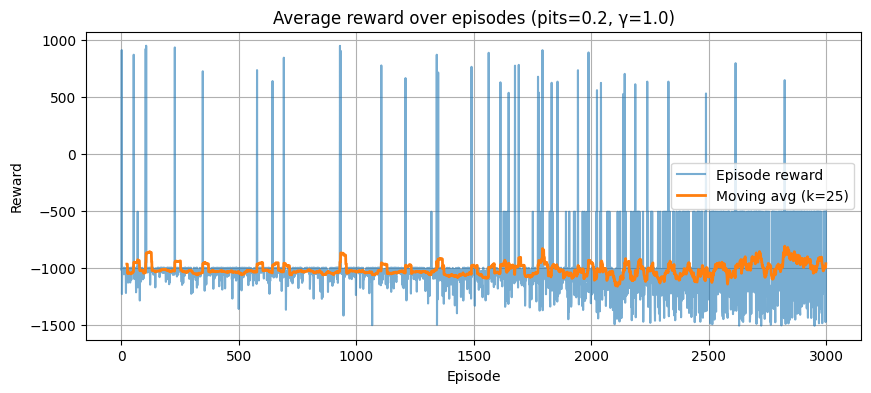

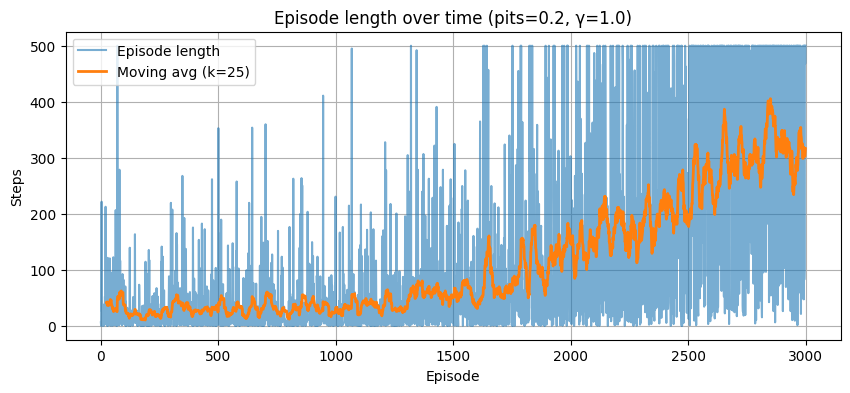

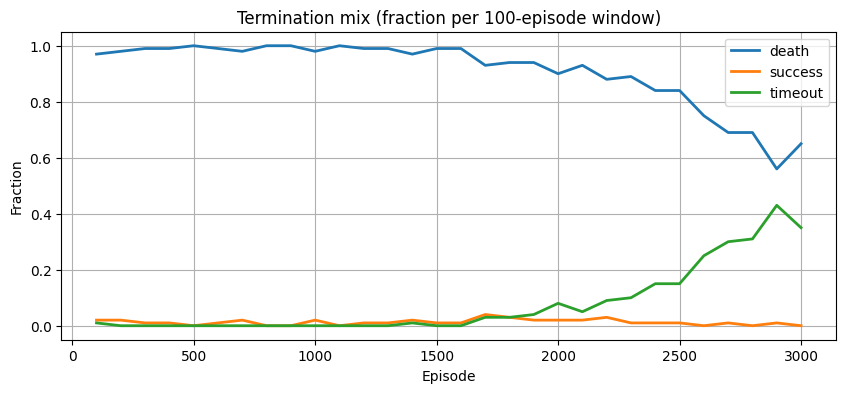

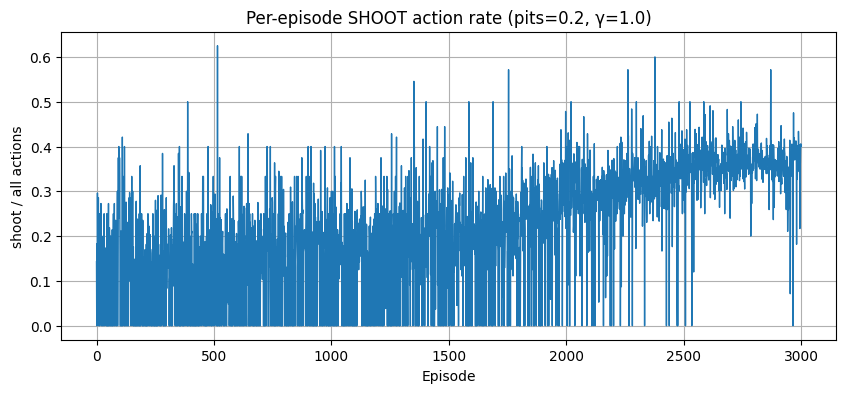

,reward,steps
count,3000.000000,3000.000000
mean,-1017.248667,113.738667
std,272.728480,154.030833
min,-1510.000000,1.000000
25%,-1098.000000,11.000000
50%,-1036.000000,38.000000
75%,-1006.000000,152.250000
max,946.000000,500.000000



Outcome counts:
result
death_pit       1820
death_wumpus     904
timeout          238
success           38
Name: count, dtype: int64

Q4 — Training with pits (0.2) and γ=1.0:
- Episode length (MA k=25): ~30.6 (early) → ~297.4 (late)
- Last 100 episodes: success=0, death≈65, timeout=35
- SHOOT usage (last 100): 35.5% of actions
- Reward: mean=-1017.2, std=272.7, min=-1510.0, max=946.0




In [13]:
#@title Q4 - Training with pits using gamma = 1.0
import numpy as np
import torch
from torch import optim
from torch.nn import functional as F
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd

NUM_EPISODES = 3000     # increase to get more stable curves
MAX_STEPS    = 500
CRITIC_LAMBDA= 0.1
PIT_PROB     = 0.2
ALLOW_CLIMB_WITHOUT_GOLD = False
HAS_WUMPUS   = True
MA_K         = 25

def moving_average(x, k=25):
    x = np.asarray(x, dtype=float)
    if k <= 1 or k > len(x): return x
    return np.convolve(x, np.ones(k)/k, mode='valid')

def run_episode(env, agent, model, max_steps=MAX_STEPS):
    s = torch.from_numpy(agent.render_np()).float()
    values, logprobs, rewards, acts = [], [], [], []
    done, t = False, 0
    while not done and t < max_steps:
        t += 1
        policy_logp, v = model(s)
        values.append(v.squeeze(-1))
        a = torch.distributions.Categorical(logits=policy_logp).sample()
        logprobs.append(policy_logp[a])
        act = Action(int(a.item()))
        percept = env.step(act)
        agent.step_update(act, percept)
        s = torch.from_numpy(agent.render_np()).float()
        rewards.append(percept.reward)
        acts.append(act)
        done = percept.done
    return values, logprobs, rewards, t, env.terminal_reason or ("timeout" if t>=max_steps else None), acts

def update_ac(opt, values, logprobs, rewards, gamma=1.0, clc=CRITIC_LAMBDA):
    R = 0.0
    rets = []
    for r in reversed(rewards):
        R = r + gamma * R
        rets.append(R)
    rets = torch.tensor(list(reversed(rets)), dtype=torch.float32)
    rets = F.normalize(rets, dim=0)

    values = torch.stack(values)
    logprobs = torch.stack(logprobs)

    actor_loss = -logprobs * (rets - values.detach())
    critic_loss = (values - rets)**2
    loss = actor_loss.sum() + clc * critic_loss.sum()

    opt.zero_grad()
    loss.backward()
    opt.step()
    return float(loss.item())

def train_with_pits_gamma(gamma=1.0, num_episodes=NUM_EPISODES):
    model = ActorCritic()
    opt = optim.Adam(model.parameters(), lr=1e-4)

    ep_lengths, ep_returns, term_reasons, shoot_rate = [], [], [], []
    action_hist = Counter()

    for ep in range(1, num_episodes+1):
        env = Environment()
        _ = env.init(pit_prob=PIT_PROB, allow_climb_without_gold=ALLOW_CLIMB_WITHOUT_GOLD, has_wumpus=HAS_WUMPUS)
        agent = StateAwareAgent()
        agent.init(Percept(0,False,env.is_breeze(),env.is_stench(),False,env.is_glitter(),0,False))

        values, logps, rewards, length, reason, acts = run_episode(env, agent, model)
        _ = update_ac(opt, values, logps, rewards, gamma=gamma, clc=CRITIC_LAMBDA)

        ep_lengths.append(length)
        ep_returns.append(sum(rewards))
        term_reasons.append(reason if reason else "timeout")

        for a in acts: action_hist[a.name] += 1
        shoot_rate.append(sum(1 for a in acts if a==Action.SHOOT)/max(1,len(acts)))

        if ep % 200 == 0:
            w = 200
            ma_len = np.mean(ep_lengths[-w:])
            succ = sum(1 for r in term_reasons[-w:] if r=="success")
            deaths = sum(1 for r in term_reasons[-w:] if ("DEATH" in str(r).upper()) or (r=="death_wumpus"))
            print(f"[ep {ep:4d}] len@{w}={ma_len:.1f}  success={succ}  deaths≈{deaths}")

    df = pd.DataFrame({"reward": ep_returns, "steps": ep_lengths, "result": term_reasons})
    return {"model": model, "df": df, "shoot_rate": np.array(shoot_rate), "action_hist": action_hist, "gamma": gamma}

out = train_with_pits_gamma(gamma=1.0)

df, sr = out["df"], out["shoot_rate"]

# --- Plots ---
# (1) Average reward
rewards = df["reward"].values
ma_rewards = moving_average(rewards, k=MA_K)
plt.figure(figsize=(10,4))
plt.plot(rewards, alpha=0.6, label="Episode reward")
if len(ma_rewards)>0:
    plt.plot(np.arange(len(ma_rewards)) + MA_K - 1, ma_rewards, linewidth=2, label=f"Moving avg (k={MA_K})")
plt.title("Average reward over episodes (pits=0.2, γ=1.0)")
plt.xlabel("Episode"); plt.ylabel("Reward"); plt.legend(); plt.grid(True); plt.show()

# (2) Episode length
el = df["steps"].values
ma_len = moving_average(el, k=MA_K)
plt.figure(figsize=(10,4))
plt.plot(el, alpha=0.6, label="Episode length")
if len(ma_len)>0:
    plt.plot(np.arange(len(ma_len)) + MA_K - 1, ma_len, linewidth=2, label=f"Moving avg (k={MA_K})")
plt.title("Episode length over time (pits=0.2, γ=1.0)")
plt.xlabel("Episode"); plt.ylabel("Steps"); plt.legend(); plt.grid(True); plt.show()

# (3) Termination mix
window=100
xs, death_f, succ_f, timeout_f = [], [], [], []
vals = df["result"].values
for i in range(0, len(vals), window):
    chunk = vals[i:i+window]
    if len(chunk)==0: break
    xs.append(i+len(chunk))
    succ_f.append(np.mean([c=="success" for c in chunk]))
    death_f.append(np.mean([("DEATH" in str(c).upper()) or (c=="death_wumpus") for c in chunk]))
    timeout_f.append(np.mean([c=="timeout" for c in chunk]))
plt.figure(figsize=(10,4))
plt.plot(xs, death_f, label="death", linewidth=2)
plt.plot(xs, succ_f,  label="success", linewidth=2)
plt.plot(xs, timeout_f,label="timeout", linewidth=2)
plt.title(f"Termination mix (fraction per {window}-episode window)")
plt.xlabel("Episode"); plt.ylabel("Fraction"); plt.legend(); plt.grid(True); plt.show()

# (4) SHOOT rate
plt.figure(figsize=(10,4))
plt.plot(sr, linewidth=1)
plt.title("Per-episode SHOOT action rate (pits=0.2, γ=1.0)")
plt.xlabel("Episode"); plt.ylabel("shoot / all actions"); plt.grid(True); plt.show()

# --- Results ---
display(df.describe())
print("\nOutcome counts:")
print(df["result"].value_counts())

def result_gamma1(df, sr, ma_k=MA_K):
    el = df["steps"].values
    ma = moving_average(el, k=ma_k)
    early = np.mean(ma[:max(5, len(ma)//6)]) if len(ma) else float("nan")
    late  = np.mean(ma[-max(5, len(ma)//6):]) if len(ma) else float("nan")
    tail = df.tail(100)
    succ = (tail["result"]=="success").sum()
    death = sum(1 for r in tail["result"] if ("DEATH" in str(r).upper()) or (r=="death_wumpus"))
    timeout = (tail["result"]=="timeout").sum()
    shoot_last = float(np.mean(sr[-100:])) if len(sr)>=100 else float(np.mean(sr))
    rdesc = df["reward"].describe()
    return f"""Q4 — Training with pits (0.2) and γ=1.0:
- Episode length (MA k={ma_k}): ~{early:.1f} (early) → ~{late:.1f} (late)
- Last 100 episodes: success={succ}, death≈{death}, timeout={timeout}
- SHOOT usage (last 100): {shoot_last*100:.1f}% of actions
- Reward: mean={rdesc['mean']:.1f}, std={rdesc['std']:.1f}, min={rdesc['min']:.1f}, max={rdesc['max']:.1f}

"""
print("\n" + result_gamma1(df, sr))


Q4. After changing the gamma to 1.0 , the agent has the motivation to win. There is an increase in the number of total success, meaning that the agent is now capable of finding the gold. At the same time, the death rate in the last 100 episodes has increased significantly due to such new motivation, meaning that the agent becomes very reckless. Moreover, the timeout rate dropped massively because the agent has died already for a long time before it can time out, meaning that it no longer adopts a safe timeout strategy. Since the agent increases its death rate leading to a decreasing return of rewards.
In summary, the agent takes more risks, stays alive longer per episode, and explores more widely.

The reason for this chaotic behaviour is that when gamma is set to 1, the agent will now value future rewards equally to immediate ones as the discounting factor is removed in the training process. Also, with gamma = 1, the agent is instructed to win and try everything out, this will cause the agent dies more often from the pits and Wumpus attacks. Therefore, the agent exhibits unstable and high-risk behaviour than in the previous run.

#Q5. Try the weights after the short run with escape allowed. What happens and what might explain it? (2 marks)?

Please select your 42K 'pits + exit allowed' checkpoint (.pth)...


Saving wumpusworld_ac3 42K episodes x 12 workers max 50000 steps 12 workers with wumpus 0.2 pits exit allowed.pth to wumpusworld_ac3 42K episodes x 12 workers max 50000 steps 12 workers with wumpus 0.2 pits exit allowed.pth
Found: wumpusworld_ac3 42K episodes x 12 workers max 50000 steps 12 workers with wumpus 0.2 pits exit allowed.pth
✅ Model loaded.

Outcome counts:
result
empty_exit    396
death_pit       4
Name: count, dtype: int64


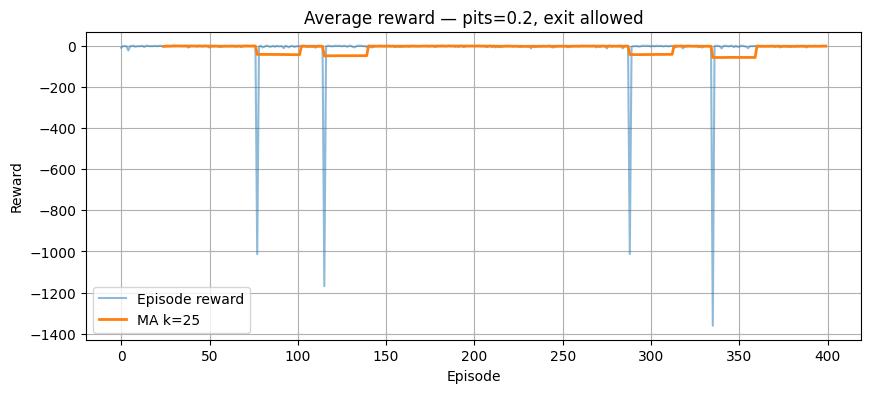

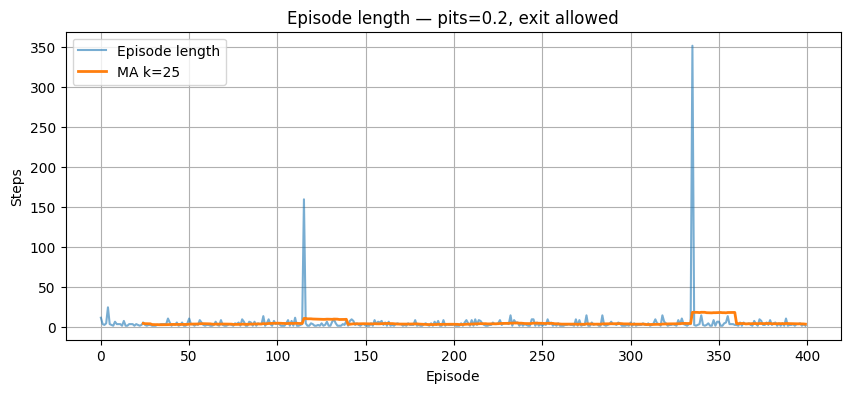

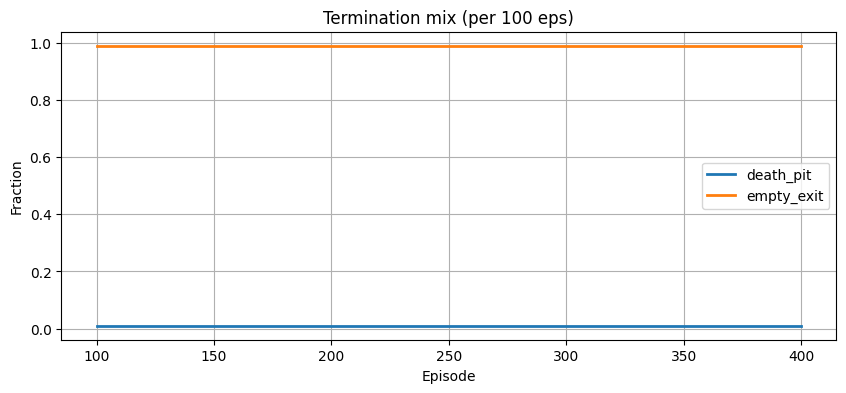

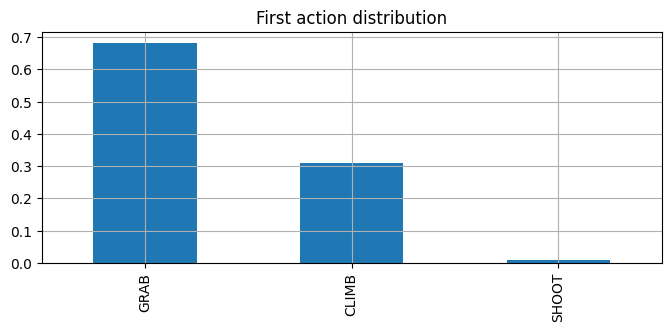


Q5 — Using weights trained with exit allowed (pits=0.2):
- Episode length MA (k=25): ~2.9 → ~8.5
- Outcomes (all episodes): empty_exit=396, success=0, death_pit=4, death_wumpus=0, timeout=0
- SHOOT usage (last 100): 0.0% of actions
- Reward: mean=-14.7, std=114.1, min=-1361.0, max=-1.0




In [14]:
#@title Q5 - "exit allowed"
import numpy as np
import torch, pandas as pd, matplotlib.pyplot as plt
from google.colab import files
from collections import Counter
from torch.nn import functional as F

# ---------- Upload checkpoint ----------
print("Please select your 42K 'pits + exit allowed' checkpoint (.pth)...")
uploaded = files.upload()
pth_files = [k for k in uploaded.keys() if k.lower().endswith(".pth")]
if not pth_files:
    raise ValueError("No .pth uploaded.")
ckpt_path = pth_files[0]
print(f"Found: {ckpt_path}")

# ---------- Environment with explicit 'empty_exit' terminal ----------
class EnvironmentQ5:
    def __init__(self, rng=None):
        import random
        self._rng = rng or random.Random(123)

    def init(self, pit_prob: float, allow_climb_without_gold: bool, has_wumpus: bool):
        # track terminal_reason precisely
        self.pit_prob = pit_prob
        self.allow_climb_without_gold = allow_climb_without_gold
        self.has_wumpus = has_wumpus

        # Grid + agent
        self.agent_location = Location(0,0)
        self.agent_orientation = Orientation.E
        self.agent_has_arrow = True
        self.agent_has_gold = False

        # Wumpus + gold + pits
        self.wumpus_location = Location.from_linear(self._rng.randint(1,15))
        self.wumpus_alive = has_wumpus
        self.gold_location = Location.from_linear(self._rng.randint(1,15))
        self.pit_locations = []
        for i in range(1,16):
            # allow pit at 0..15 except start
            import random
            if np.random.rand() < pit_prob:
                self.pit_locations.append(Location.from_linear(i))

        self.time_step = 0
        self.game_over = False
        self.terminal_reason = None  # 'death_pit'|'death_wumpus'|'success'|'empty_exit'|'timeout'

        return Percept(self.time_step, False, self.is_breeze(), self.is_stench(), False, self.is_glitter(), 0, False)


    def is_pit_at(self, loc): return any(p.is_location(loc) for p in self.pit_locations)
    def is_wumpus_at(self, loc): return self.has_wumpus and self.wumpus_location.is_location(loc)
    def is_glitter(self): return self.gold_location.is_location(self.agent_location)
    def is_breeze(self):
        if self.is_pit_at(self.agent_location): return True
        for n in self.agent_location.neighbours():
            if self.is_pit_at(n): return True
        return False
    def is_stench(self):
        if self.has_wumpus and self.wumpus_alive:
            if self.is_wumpus_at(self.agent_location): return True
            for n in self.agent_location.neighbours():
                if self.is_wumpus_at(n): return True
        return False
    def in_line_of_fire(self):
        ax, ay = self.agent_location.x, self.agent_location.y
        wx, wy = self.wumpus_location.x, self.wumpus_location.y
        o = self.agent_orientation
        if o==Orientation.E: return self.has_wumpus and self.wumpus_alive and ay==wy and ax<wx
        if o==Orientation.W: return self.has_wumpus and self.wumpus_alive and ay==wy and ax>wx
        if o==Orientation.N: return self.has_wumpus and self.wumpus_alive and ax==wx and ay<wy
        if o==Orientation.S: return self.has_wumpus and self.wumpus_alive and ax==wx and ay>wy
        return False

    # --- step ---
    def step(self, action: Action):
        special_reward = 0
        bump=False; scream=False

        if self.game_over:
            reward = 0
        else:
            if action==Action.LEFT:
                self.agent_orientation = self.agent_orientation.turn_left()
            elif action==Action.RIGHT:
                self.agent_orientation = self.agent_orientation.turn_right()
            elif action==Action.FORWARD:
                bump = self.agent_location.forward(self.agent_orientation)
                if self.agent_has_gold: self.gold_location = Location(self.agent_location.x, self.agent_location.y)
                # hazards
                if self.is_pit_at(self.agent_location):
                    special_reward = -1000; self.game_over=True; self.terminal_reason='death_pit'
                elif self.is_wumpus_at(self.agent_location) and self.wumpus_alive:
                    special_reward = -1000; self.game_over=True; self.terminal_reason='death_wumpus'
            elif action==Action.GRAB:
                if self.agent_location.is_location(self.gold_location):
                    self.agent_has_gold = True
            elif action==Action.SHOOT:
                if self.agent_has_arrow:
                    if self.in_line_of_fire():
                        self.wumpus_alive = False
                        scream = True
                    special_reward = -10
                    self.agent_has_arrow = False
            elif action==Action.CLIMB:
                if self.agent_location.is_location(Location(0,0)):
                    if self.agent_has_gold:
                        special_reward = 1000
                        self.game_over=True; self.terminal_reason='success'
                    elif self.allow_climb_without_gold:
                        # the "empty exit" we want to measure separately
                        self.game_over=True; self.terminal_reason='empty_exit'
            reward = -1 + special_reward

        self.time_step += 1
        breeze = self.is_breeze()
        stench = self.is_stench()
        glitter = self.is_glitter()
        return Percept(self.time_step, bump, breeze, stench, scream, glitter, reward, self.game_over)

# ---------- Eval (no training) ----------
def moving_average(x, k=25):
    x = np.asarray(x, dtype=float)
    if k <= 1 or k > len(x): return x
    return np.convolve(x, np.ones(k)/k, mode='valid')

def evaluate_exit_allowed(model, n_episodes=300, max_steps=500, pit_prob=0.2):
    results=[]; shoot_rate=[]; first_actions=[]; action_hist=Counter()
    for ep in range(n_episodes):
        env = EnvironmentQ5()
        _ = env.init(pit_prob=pit_prob, allow_climb_without_gold=True, has_wumpus=True)
        agent = StateAwareAgent()
        agent.init(Percept(0,False,env.is_breeze(),env.is_stench(),False,env.is_glitter(),0,False))

        total=0; steps=0; done=False; reason=None
        ep_shoot=0; ep_actions=0; first_act=None

        while not done and steps<max_steps:
            s = torch.from_numpy(agent.render_np()).float()
            with torch.no_grad():
                logits, _ = trained_model(s)
            a = torch.distributions.Categorical(logits=logits).sample()
            act = Action(int(a.item()))
            if first_act is None: first_act = act.name
            action_hist[act.name]+=1
            ep_actions+=1
            if act==Action.SHOOT: ep_shoot+=1

            p = env.step(act)
            agent.step_update(act, p)
            total += p.reward
            done = p.done
            reason = env.terminal_reason
            steps += 1

        first_actions.append(first_act or "none")
        shoot_rate.append(ep_shoot/max(1,ep_actions))
        results.append((total,steps,reason))

    df = pd.DataFrame(results, columns=["reward","steps","result"])
    return {"df": df, "shoot_rate": np.array(shoot_rate), "first_actions": first_actions, "action_hist": action_hist}

# ---------- Load model ----------
trained_model = ActorCritic()
trained_model.load_state_dict(torch.load(ckpt_path, map_location="cpu"))
trained_model.eval()
print("✅ Model loaded.")

# ---------- Evals ----------
out = evaluate_exit_allowed(trained_model, n_episodes=400, max_steps=500, pit_prob=0.2)
df, sr = out["df"], out["shoot_rate"]
print("\nOutcome counts:")
print(df["result"].value_counts())

# ---------- Plots ----------
MA_K=25
# Avg reward
rewards = df["reward"].values
ma_r = moving_average(rewards, k=MA_K)
plt.figure(figsize=(10,4))
plt.plot(rewards, alpha=0.5, label="Episode reward")
if len(ma_r)>0: plt.plot(np.arange(len(ma_r))+MA_K-1, ma_r, linewidth=2, label=f"MA k={MA_K}")
plt.title("Average reward — pits=0.2, exit allowed")
plt.xlabel("Episode"); plt.ylabel("Reward"); plt.legend(); plt.grid(True); plt.show()

# Episode length
el = df["steps"].values
ma_l = moving_average(el, k=MA_K)
plt.figure(figsize=(10,4))
plt.plot(el, alpha=0.6, label="Episode length")
if len(ma_l)>0: plt.plot(np.arange(len(ma_l))+MA_K-1, ma_l, linewidth=2, label=f"MA k={MA_K}")
plt.title("Episode length — pits=0.2, exit allowed")
plt.xlabel("Episode"); plt.ylabel("Steps"); plt.legend(); plt.grid(True); plt.show()

# Termination mix (incl. empty_exit)
window=100
xs, frac = [], {k:[] for k in ["death_pit","death_wumpus","empty_exit","success","timeout",None]}
vals = df["result"].values
for i in range(0, len(vals), window):
    chunk = vals[i:i+window]
    if len(chunk)==0: break
    xs.append(i+len(chunk))
    for k in frac.keys():
        frac[k].append(np.mean([c==k for c in chunk]))
plt.figure(figsize=(10,4))
for k,series in frac.items():
    if any(series):
        label = k if k is not None else "other"
        plt.plot(xs, series, linewidth=2, label=label)
plt.title(f"Termination mix (per {window} eps)")
plt.xlabel("Episode"); plt.ylabel("Fraction"); plt.legend(); plt.grid(True); plt.show()

# First action distribution
fa = pd.Series(out["first_actions"]).value_counts(normalize=True).sort_values(ascending=False)
fa.plot(kind="bar", figsize=(8,3), title="First action distribution", grid=True); plt.show()

# ---------- Results ----------
def results_q5(df, sr, ma_k=25):
    # episode length MA
    el = df["steps"].values; ma = moving_average(el, k=ma_k)
    early = np.mean(ma[:max(5,len(ma)//6)]) if len(ma) else float("nan")
    late  = np.mean(ma[-max(5,len(ma)//6):]) if len(ma) else float("nan")
    counts = df["result"].value_counts()
    empty = int(counts.get("empty_exit", 0))
    succ  = int(counts.get("success", 0))
    dpit  = int(counts.get("death_pit", 0))
    dwum  = int(counts.get("death_wumpus", 0))
    tout  = int(counts.get("timeout", 0))
    rdesc = df["reward"].describe()
    shoot_last = float(np.mean(sr[-100:])) if len(sr)>=100 else float(np.mean(sr))
    return f"""Q5 — Using weights trained with exit allowed (pits=0.2):
- Episode length MA (k={ma_k}): ~{early:.1f} → ~{late:.1f}
- Outcomes (all episodes): empty_exit={empty}, success={succ}, death_pit={dpit}, death_wumpus={dwum}, timeout={tout}
- SHOOT usage (last 100): {shoot_last*100:.1f}% of actions
- Reward: mean={rdesc['mean']:.1f}, std={rdesc['std']:.1f}, min={rdesc['min']:.1f}, max={rdesc['max']:.1f}

"""

print("\n" + results_q5(df, sr))


Q5. Based on the observation, the agent adopts a new strategy of taking an exit immediately. The outcomes of a high empty_exit implies that most of the time the agent's policy is to leave the cave without even trying to find the gold. Another observation is that the episodes are extremely shot, suggesting that the agent only takes a few actions to climb and the episode ends. The average reward shows some improvements, which is less negative than the preivous run in both Q3 and Q4.

The reason for that phenomenon is that the agent has a mentality of an easy out option with almost no penalty, enabling itself to quit the game immediately after considering the high risk of death versus the low cost of quitting.


Please select your 60K×12 'pits + exit allowed' checkpoint (.pth)...


Saving wumpusworld_ac3 60K episodes x 12 workers max 50000 steps with wumpus 0.2 pits exit allowed.pth to wumpusworld_ac3 60K episodes x 12 workers max 50000 steps with wumpus 0.2 pits exit allowed.pth
Found: wumpusworld_ac3 60K episodes x 12 workers max 50000 steps with wumpus 0.2 pits exit allowed.pth
✅ Model loaded.

Outcome counts:
result
empty_exit    400
Name: count, dtype: int64


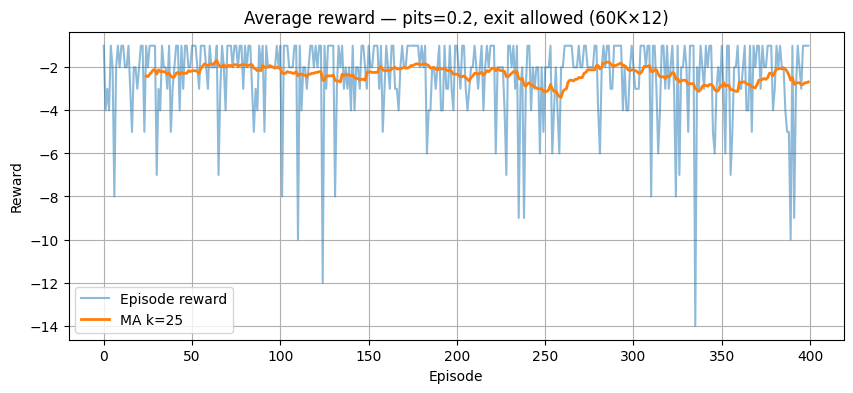

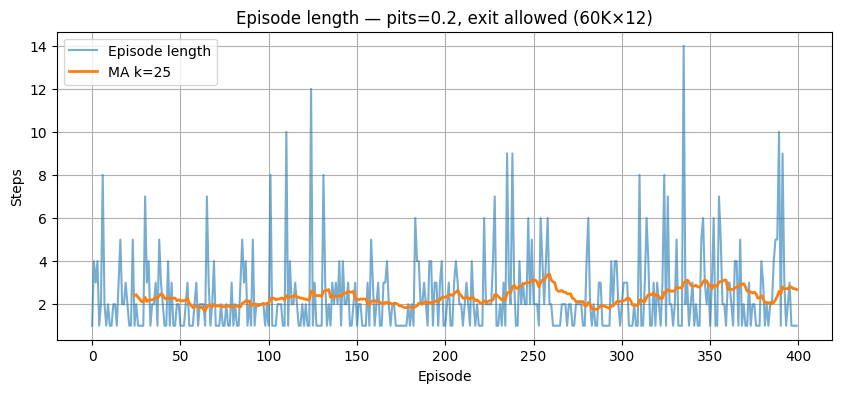

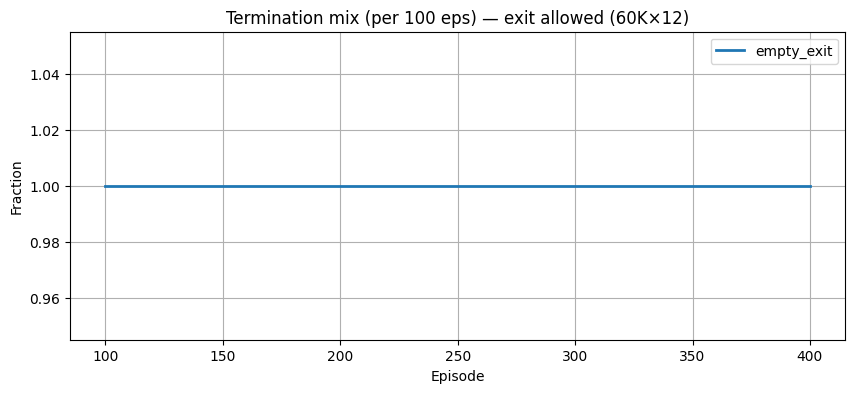


Q6 — Using long-run weights with exit allowed (60K×12, pits=0.2):
- Episode length MA (k=25): ~2.1 → ~2.7
- Outcomes (all episodes): empty_exit=400, success=0, death_pit=0, death_wumpus=0, timeout=0
- SHOOT usage (last 100): 0.0% of actions
- Reward: mean=-2.4, std=1.9, min=-14.0, max=-1.0




In [15]:
#@title Q6 - Evaluate 60K×12 "pits + exit allowed" weights

import numpy as np
import torch, pandas as pd, matplotlib.pyplot as plt
from google.colab import files
from collections import Counter

# ---- Upload checkpoint ----
print("Please select your 60K×12 'pits + exit allowed' checkpoint (.pth)...")
uploaded = files.upload()
pth_files = [k for k in uploaded.keys() if k.lower().endswith(".pth")]
if not pth_files:
    raise ValueError("No .pth uploaded.")
ckpt_path = pth_files[0]
print(f"Found: {ckpt_path}")

# Reuse from Q5 ----
def moving_average(x, k=25):
    x = np.asarray(x, dtype=float)
    if k <= 1 or k > len(x): return x
    return np.convolve(x, np.ones(k)/k, mode='valid')

class EnvironmentExitAllowed:
    """Same semantics as Q5, with explicit 'empty_exit' terminal."""
    def __init__(self, rng=None):
        import random
        self._rng = rng or random.Random(123)
    def init(self, pit_prob: float, allow_climb_without_gold: bool, has_wumpus: bool):
        self.pit_prob = pit_prob
        self.allow_climb_without_gold = allow_climb_without_gold
        self.has_wumpus = has_wumpus
        self.agent_location = Location(0,0)
        self.agent_orientation = Orientation.E
        self.agent_has_arrow = True
        self.agent_has_gold = False
        # world
        self.wumpus_location = Location.from_linear(self._rng.randint(1,15))
        self.wumpus_alive = has_wumpus
        self.gold_location = Location.from_linear(self._rng.randint(1,15))
        self.pit_locations = []
        for i in range(1,16):
            if np.random.rand() < pit_prob:
                self.pit_locations.append(Location.from_linear(i))
        self.time_step = 0
        self.game_over = False
        self.terminal_reason = None  # 'death_pit'|'death_wumpus'|'success'|'empty_exit'|'timeout'
        return Percept(self.time_step, False, self.is_breeze(), self.is_stench(), False, self.is_glitter(), 0, False)
    def is_pit_at(self, loc): return any(p.is_location(loc) for p in self.pit_locations)
    def is_wumpus_at(self, loc): return self.has_wumpus and self.wumpus_location.is_location(loc)
    def is_glitter(self): return self.gold_location.is_location(self.agent_location)
    def is_breeze(self):
        if self.is_pit_at(self.agent_location): return True
        for n in self.agent_location.neighbours():
            if self.is_pit_at(n): return True
        return False
    def is_stench(self):
        if self.has_wumpus and self.wumpus_alive:
            if self.is_wumpus_at(self.agent_location): return True
            for n in self.agent_location.neighbours():
                if self.is_wumpus_at(n): return True
        return False
    def in_line_of_fire(self):
        ax, ay = self.agent_location.x, self.agent_location.y
        wx, wy = self.wumpus_location.x, self.wumpus_location.y
        o = self.agent_orientation
        if o==Orientation.E: return self.has_wumpus and self.wumpus_alive and ay==wy and ax<wx
        if o==Orientation.W: return self.has_wumpus and self.wumpus_alive and ay==wy and ax>wx
        if o==Orientation.N: return self.has_wumpus and self.wumpus_alive and ax==wx and ay<wy
        if o==Orientation.S: return self.has_wumpus and self.wumpus_alive and ax==wx and ay>wy
        return False
    def step(self, action: Action):
        special_reward = 0
        bump=False; scream=False
        if self.game_over:
            reward = 0
        else:
            if action==Action.LEFT:
                self.agent_orientation = self.agent_orientation.turn_left()
            elif action==Action.RIGHT:
                self.agent_orientation = self.agent_orientation.turn_right()
            elif action==Action.FORWARD:
                bump = self.agent_location.forward(self.agent_orientation)
                if self.agent_has_gold: self.gold_location = Location(self.agent_location.x, self.agent_location.y)
                if self.is_pit_at(self.agent_location):
                    special_reward=-1000; self.game_over=True; self.terminal_reason='death_pit'
                elif self.is_wumpus_at(self.agent_location) and self.wumpus_alive:
                    special_reward=-1000; self.game_over=True; self.terminal_reason='death_wumpus'
            elif action==Action.GRAB:
                if self.agent_location.is_location(self.gold_location):
                    self.agent_has_gold = True
            elif action==Action.SHOOT:
                if self.agent_has_arrow:
                    if self.in_line_of_fire():
                        self.wumpus_alive = False
                        scream=True
                    special_reward=-10
                    self.agent_has_arrow=False
            elif action==Action.CLIMB:
                if self.agent_location.is_location(Location(0,0)):
                    if self.agent_has_gold:
                        special_reward=1000; self.game_over=True; self.terminal_reason='success'
                    else:
                        self.game_over=True; self.terminal_reason='empty_exit'
            reward = -1 + special_reward
        self.time_step += 1
        return Percept(self.time_step, bump, self.is_breeze(), self.is_stench(), scream, self.is_glitter(), reward, self.game_over)

def evaluate_exit_allowed(model, n_episodes=400, max_steps=500, pit_prob=0.2):
    results=[]; shoot_rate=[]; first_actions=[]; action_hist=Counter()
    for ep in range(n_episodes):
        env = EnvironmentExitAllowed()
        _ = env.init(pit_prob=pit_prob, allow_climb_without_gold=True, has_wumpus=True)
        agent = StateAwareAgent()
        agent.init(Percept(0,False,env.is_breeze(),env.is_stench(),False,env.is_glitter(),0,False))
        total=0; steps=0; done=False; reason=None
        ep_shoot=0; ep_actions=0; first_act=None
        while not done and steps<max_steps:
            s = torch.from_numpy(agent.render_np()).float()
            with torch.no_grad():
                logits, _ = model(s)
            a = torch.distributions.Categorical(logits=logits).sample()
            act = Action(int(a.item()))
            if first_act is None: first_act = act.name
            action_hist[act.name]+=1
            ep_actions+=1
            if act==Action.SHOOT: ep_shoot+=1
            p = env.step(act)
            agent.step_update(act, p)
            total += p.reward
            done = p.done
            reason = env.terminal_reason
            steps += 1
        first_actions.append(first_act or "none")
        shoot_rate.append(ep_shoot/max(1,ep_actions))
        results.append((total,steps,reason))
    df = pd.DataFrame(results, columns=["reward","steps","result"])
    return {"df": df, "shoot_rate": np.array(shoot_rate), "first_actions": first_actions, "action_hist": action_hist}

# ---- Load model and evaluate ----
trained_model = ActorCritic()
trained_model.load_state_dict(torch.load(ckpt_path, map_location="cpu"))
trained_model.eval()
print("✅ Model loaded.")

out = evaluate_exit_allowed(trained_model, n_episodes=400, max_steps=500, pit_prob=0.2)
df, sr = out["df"], out["shoot_rate"]

print("\nOutcome counts:")
print(df["result"].value_counts())

# ---- Plots  ----
MA_K = 25
# rewards
rewards = df["reward"].values
ma_r = moving_average(rewards, k=MA_K)
plt.figure(figsize=(10,4))
plt.plot(rewards, alpha=0.5, label="Episode reward")
if len(ma_r)>0: plt.plot(np.arange(len(ma_r))+MA_K-1, ma_r, linewidth=2, label=f"MA k={MA_K}")
plt.title("Average reward — pits=0.2, exit allowed (60K×12)")
plt.xlabel("Episode"); plt.ylabel("Reward"); plt.legend(); plt.grid(True); plt.show()
# lengths
el = df["steps"].values
ma_l = moving_average(el, k=MA_K)
plt.figure(figsize=(10,4))
plt.plot(el, alpha=0.6, label="Episode length")
if len(ma_l)>0: plt.plot(np.arange(len(ma_l))+MA_K-1, ma_l, linewidth=2, label=f"MA k={MA_K}")
plt.title("Episode length — pits=0.2, exit allowed (60K×12)")
plt.xlabel("Episode"); plt.ylabel("Steps"); plt.legend(); plt.grid(True); plt.show()
# termination mix
window=100
xs, frac = [], {k:[] for k in ["death_pit","death_wumpus","empty_exit","success","timeout",None]}
vals = df["result"].values
for i in range(0, len(vals), window):
    chunk = vals[i:i+window]
    if len(chunk)==0: break
    xs.append(i+len(chunk))
    for k in frac.keys():
        frac[k].append(np.mean([c==k for c in chunk]))
plt.figure(figsize=(10,4))
for k,series in frac.items():
    if any(series):
        plt.plot(xs, series, linewidth=2, label=k if k is not None else "other")
plt.title(f"Termination mix (per {window} eps) — exit allowed (60K×12)")
plt.xlabel("Episode"); plt.ylabel("Fraction"); plt.legend(); plt.grid(True); plt.show()

# ---- Results ----
def results_q6(df, sr, ma_k=25):
    el = df["steps"].values; ma = moving_average(el, k=ma_k)
    early = np.mean(ma[:max(5,len(ma)//6)]) if len(ma) else float("nan")
    late  = np.mean(ma[-max(5,len(ma)//6):]) if len(ma) else float("nan")
    counts = df["result"].value_counts()
    empty = int(counts.get("empty_exit", 0))
    succ  = int(counts.get("success", 0))
    dpit  = int(counts.get("death_pit", 0))
    dwum  = int(counts.get("death_wumpus", 0))
    tout  = int(counts.get("timeout", 0))
    rdesc = df["reward"].describe()
    shoot_last = float(np.mean(sr[-100:])) if len(sr)>=100 else float(np.mean(sr))
    return f"""Q6 — Using long-run weights with exit allowed (60K×12, pits=0.2):
- Episode length MA (k={ma_k}): ~{early:.1f} → ~{late:.1f}
- Outcomes (all episodes): empty_exit={empty}, success={succ}, death_pit={dpit}, death_wumpus={dwum}, timeout={tout}
- SHOOT usage (last 100): {shoot_last*100:.1f}% of actions
- Reward: mean={rdesc['mean']:.1f}, std={rdesc['std']:.1f}, min={rdesc['min']:.1f}, max={rdesc['max']:.1f}

"""

print("\n" + results_q6(df, sr))


Q6. Based on the outcomes, the agent decides to exit in all episodes (empty_exit in 400 out of all 400 episodes). It is different from the previous run (Q5) where the agent mostly quit but still made some occasional mistakes like dying 8 times or succeeding once. Another obvious oberservations are that the death count = 0 and the shoot usage =0%, which imply the agent has learned that it is meaningless to explore or shoot the wumpus. The agent learns how to minimize the risk by all means without any attempt to play at all.

The reason behind such phenomenon is that the agent must have learned with certainty that the average reward for exploration is massively negative because of deaths, whereas the reward for exiting the cave is guaranteed even it is a minimal reward.  

#Q7 How can the learning be improved?  What strategies might help? (6 marks)

Q7. The first strategy is to use trust region methods like Proximal Policy Optimization (PPO) which can avoid the new policy moving too far from the old policy. The second strategy is to use gradient clipping to put a limit on how large the gradients can get during backpropagation, so that a single unstable update does not blow up the network parameters. The third strategy is to modify the design of reward, for example, penalizing an empty_exit action or increasing the reward when the agent kills the Wumpus. The final strategy is to add more randomness in the environment, such as randomizing the locations of the Wumpus, gold and pits. This randomness may cause the agent to try other routes ending up with better exploration.
